In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

FileNotFoundError: ignored

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df = df.dropna(subset=["description", "points"])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


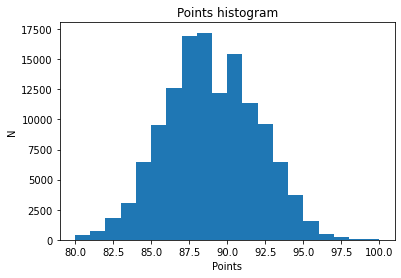

In [ ]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [ ]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.32213867, -0.11397372,  0.12314521, ...,  0.09228322,
        -0.1894445 ,  0.01205883],
       [ 0.3345343 , -0.2977466 , -0.13371924, ...,  0.24531348,
         0.07226244, -0.05761432],
       [ 0.3464695 , -0.23744574, -0.10765769, ..., -0.133946  ,
        -0.32243535,  0.01504677],
       ...,
       [ 0.34781176, -0.18539087,  0.01202014, ...,  0.03814878,
        -0.11119482, -0.02451738],
       [ 0.39406633, -0.06647005, -0.02168484, ..., -0.03580245,
        -0.34096584,  0.15480824],
       [ 0.23895073, -0.3953955 ,  0.1023175 , ..., -0.0930256 ,
        -0.32504383, -0.10729512]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

102/102 [==============================] - 2s 14ms/step - loss: 0.6859 - accuracy: 0.5949


[0.6859393119812012, 0.5949353575706482]

In [ ]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 12ms/step - loss: 0.6858 - accuracy: 0.5964


[0.6857976913452148, 0.5963683724403381]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 63s 597ms/step - loss: 0.6172 - accuracy: 0.6314 - val_loss: 0.5027 - val_accuracy: 0.7769
Epoch 2/5
102/102 [==============================] - 61s 599ms/step - loss: 0.4700 - accuracy: 0.7783 - val_loss: 0.4016 - val_accuracy: 0.8179
Epoch 3/5
102/102 [==============================] - 59s 577ms/step - loss: 0.3978 - accuracy: 0.8283 - val_loss: 0.3809 - val_accuracy: 0.8253
Epoch 4/5
102/102 [==============================] - 59s 577ms/step - loss: 0.3642 - accuracy: 0.8481 - val_loss: 0.3710 - val_accuracy: 0.8307
Epoch 5/5
102/102 [==============================] - 60s 581ms/step - loss: 0.3421 - accuracy: 0.8597 - val_loss: 0.3750 - val_accuracy: 0.8296


In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 2s 120ms/step - loss: 0.3803 - accuracy: 0.8321


[0.3803272843360901, 0.8320510983467102]

# LSTM

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 186ms/step - loss: 0.6927 - accuracy: 0.5360


[0.6927294731140137, 0.5360468029975891]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 96s 503ms/step - loss: 0.5570 - accuracy: 0.7030 - val_loss: 0.3759 - val_accuracy: 0.8258
Epoch 2/5
102/102 [==============================] - 52s 506ms/step - loss: 0.3704 - accuracy: 0.8342 - val_loss: 0.3480 - val_accuracy: 0.8387
Epoch 3/5
102/102 [==============================] - 52s 511ms/step - loss: 0.3501 - accuracy: 0.8445 - val_loss: 0.3502 - val_accuracy: 0.8374
Epoch 4/5
102/102 [==============================] - 57s 553ms/step - loss: 0.3426 - accuracy: 0.8468 - val_loss: 0.3453 - val_accuracy: 0.8396
Epoch 5/5
102/102 [==============================] - 52s 507ms/step - loss: 0.3386 - accuracy: 0.8486 - val_loss: 0.3424 - val_accuracy: 0.8415


In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 4s 273ms/step - loss: 0.3497 - accuracy: 0.8416


[0.3497326672077179, 0.8415910005569458]